In [9]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Text Processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, roc_curve)

In [12]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [13]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

In [14]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [15]:
# STEP 1: LOAD AND EXPLORE DATA
# ============================================================================
print("="*80)
print("STEP 1: DATA LOADING AND EXPLORATORY DATA ANALYSIS")
print("="*80)

# Load the dataset
# Note: Replace with actual file path
print("\n[1.1] Loading Dataset...")
df = pd.read_csv('complaints.csv', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")

# Display basic information
print("\n[1.2] Dataset Info:")
print(df.info())

print("\n[1.3] First few rows:")
print(df.head())

# Check for missing values
print("\n[1.4] Missing Values:")
missing_data = df.isnull().sum()
missing_percent = 100 * missing_data / len(df)
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

# ============================================================================
# STEP 2: DATA PREPROCESSING AND FILTERING
# ============================================================================
print("\n" + "="*80)
print("STEP 2: DATA PREPROCESSING")
print("="*80)

# Filter for the 4 specific product categories
target_products = [
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Debt collection',
    'Consumer Loan',
    'Mortgage'
]

# Alternative product names (the dataset might have variations)
product_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Credit reporting, repair, or other': 0,
    'Credit reporting': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

print("\n[2.1] Filtering relevant product categories...")
# Filter data
df_filtered = df[df['Product'].isin(product_mapping.keys())].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")

# Create target labels
df_filtered['Label'] = df_filtered['Product'].map(product_mapping)

# Select relevant columns
text_column = 'Consumer complaint narrative'  # or 'Complaint narrative' depending on dataset
if text_column not in df_filtered.columns:
    text_column = 'Consumer Complaint Narrative'
if text_column not in df_filtered.columns:
    text_column = 'Issue'  # Fallback

df_filtered = df_filtered[[text_column, 'Product', 'Label']].copy()
df_filtered.rename(columns={text_column: 'complaint_text'}, inplace=True)

# Remove null complaints
df_filtered = df_filtered[df_filtered['complaint_text'].notna()].copy()
df_filtered['complaint_text'] = df_filtered['complaint_text'].astype(str)

print(f"Final dataset shape after cleaning: {df_filtered.shape}")

STEP 1: DATA LOADING AND EXPLORATORY DATA ANALYSIS

[1.1] Loading Dataset...
Dataset shape: (11522175, 18)

Column names:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

[1.2] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11522175 entries, 0 to 11522174
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       obj


[2.2] Class Distribution:
Label
0    838863
1    371629
2      9461
3    134837
Name: count, dtype: int64

✓ EDA visualizations saved as 'eda_visualizations.png'

[2.3] Statistical Summary of Text Features:
        text_length    word_count
count  1.354790e+06  1.354790e+06
mean   9.755866e+02  1.730336e+02
std    1.264125e+03  2.201493e+02
min    4.000000e+00  1.000000e+00
25%    3.300000e+02  5.900000e+01
50%    6.280000e+02  1.120000e+02
75%    1.143000e+03  2.040000e+02
max    3.261600e+04  6.095000e+03

STEP 3: TEXT PRE-PROCESSING

[3.1] Applying text preprocessing...

[3.2] Sample of original vs cleaned text:

Original: These are not my accounts....
Cleaned: account...

Original: I wrote three requests, the unverified accounts listed below still remain on my credit report in violation of Federal Law. Equifax is under FCRA law to obtain the of the original creditors documentati...
Cleaned: wrote three request unverified account listed still remain credit report violation federal 

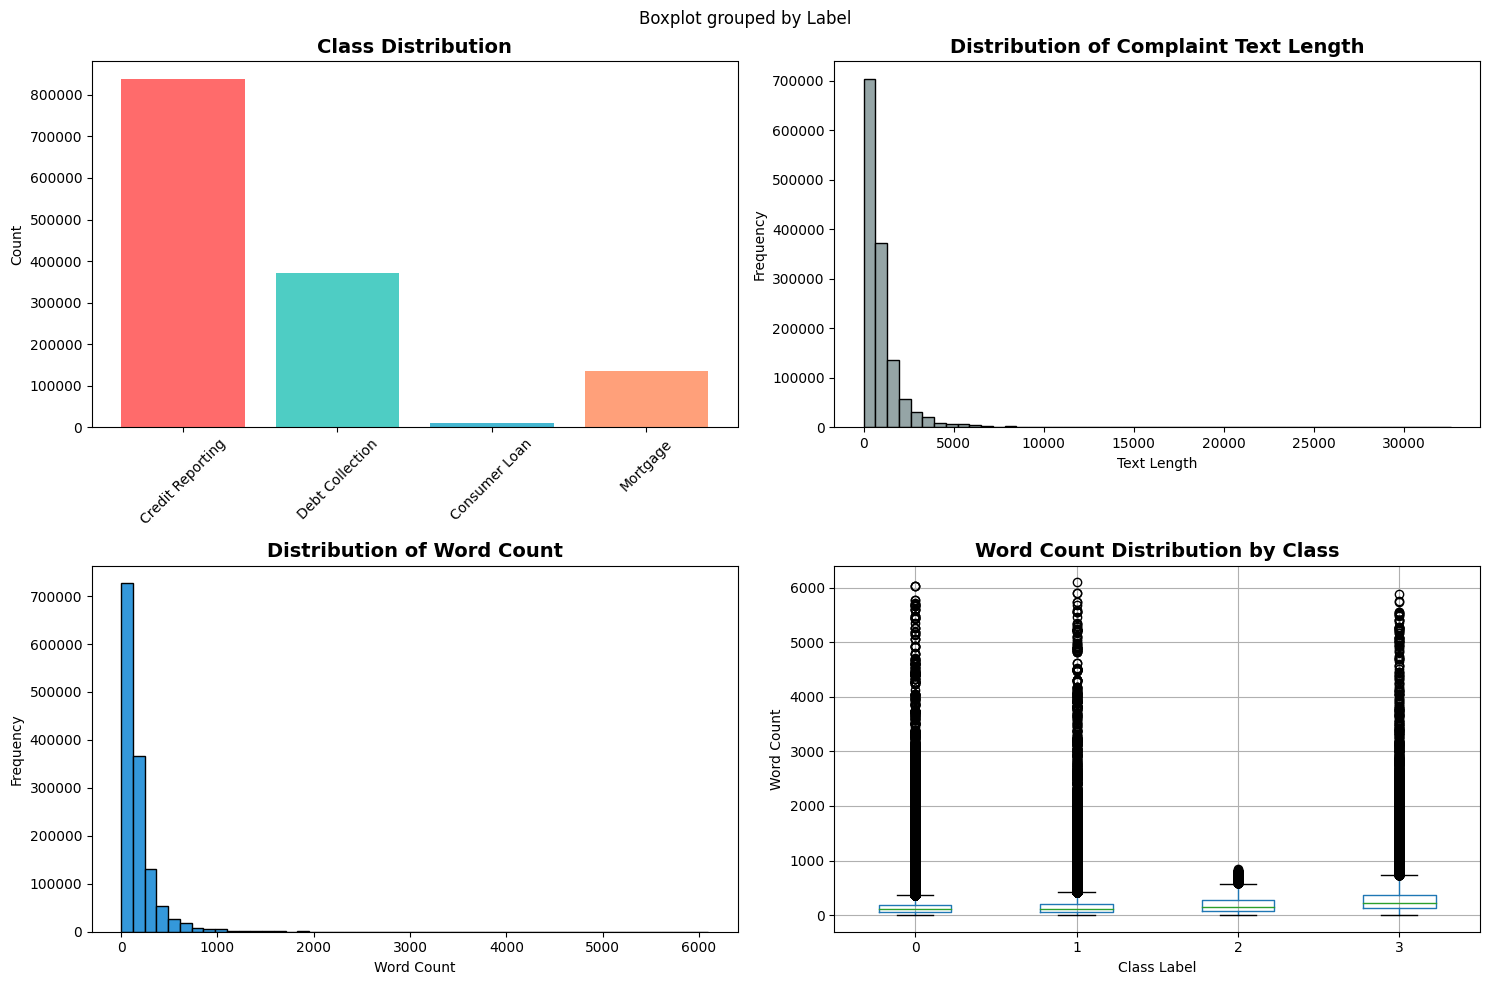

In [16]:

# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================
print("\n[2.2] Class Distribution:")
class_dist = df_filtered['Label'].value_counts().sort_index()
print(class_dist)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Class Distribution
class_names = ['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']
axes[0, 0].bar(class_names, class_dist.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Text Length Distribution
df_filtered['text_length'] = df_filtered['complaint_text'].str.len()
axes[0, 1].hist(df_filtered['text_length'], bins=50, color='#95A5A6', edgecolor='black')
axes[0, 1].set_title('Distribution of Complaint Text Length', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Text Length')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Word Count Distribution
df_filtered['word_count'] = df_filtered['complaint_text'].str.split().str.len()
axes[1, 0].hist(df_filtered['word_count'], bins=50, color='#3498DB', edgecolor='black')
axes[1, 0].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Box plot for word count by class
df_filtered.boxplot(column='word_count', by='Label', ax=axes[1, 1])
axes[1, 1].set_title('Word Count Distribution by Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Class Label')
axes[1, 1].set_ylabel('Word Count')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ EDA visualizations saved as 'eda_visualizations.png'")

# Statistical Summary
print("\n[2.3] Statistical Summary of Text Features:")
print(df_filtered[['text_length', 'word_count']].describe())

# ============================================================================
# STEP 3: TEXT PRE-PROCESSING
# ============================================================================
print("\n" + "="*80)
print("STEP 3: TEXT PRE-PROCESSING")
print("="*80)

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Comprehensive text preprocessing pipeline
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
              if word not in stop_words and len(word) > 2]
    
    # Join tokens back into string
    return ' '.join(tokens)

print("\n[3.1] Applying text preprocessing...")
df_filtered['cleaned_text'] = df_filtered['complaint_text'].apply(preprocess_text)

print("\n[3.2] Sample of original vs cleaned text:")
for i in range(min(2, len(df_filtered))):
    print(f"\nOriginal: {df_filtered.iloc[i]['complaint_text'][:200]}...")
    print(f"Cleaned: {df_filtered.iloc[i]['cleaned_text'][:200]}...")

# Remove empty cleaned texts
df_filtered = df_filtered[df_filtered['cleaned_text'].str.len() > 0].copy()
print(f"\nFinal dataset shape: {df_filtered.shape}")

In [17]:

# ============================================================================
# STEP 4: FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE ENGINEERING")
print("="*80)

# Split data
X = df_filtered['cleaned_text']
y = df_filtered['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# TF-IDF Vectorization
print("\n[4.1] Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")


STEP 4: FEATURE ENGINEERING

Training set size: 1083830
Test set size: 270958

[4.1] Creating TF-IDF features...
TF-IDF feature matrix shape: (1083830, 5000)


In [18]:
# STEP 5: MODEL SELECTION AND TRAINING
# ============================================================================
print("\n" + "="*80)
print("STEP 5: MULTI-CLASSIFICATION MODEL SELECTION")
print("="*80)

# Dictionary to store models and their results
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, 
                                               class_weight='balanced'),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss', 
                            use_label_encoder=False)
}

results = {}

print("\n[5.1] Training and evaluating models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}\n")


STEP 5: MULTI-CLASSIFICATION MODEL SELECTION

[5.1] Training and evaluating models...

Training Logistic Regression...
  Accuracy: 0.8744
  F1-Score: 0.8860

Training Multinomial Naive Bayes...
  Accuracy: 0.8641
  F1-Score: 0.8640

Training Linear SVM...
  Accuracy: 0.8983
  F1-Score: 0.9023

Training XGBoost...
  Accuracy: 0.9093
  F1-Score: 0.9078




STEP 6: MODEL PERFORMANCE COMPARISON

                  Model  Accuracy  Precision   Recall  F1-Score
                XGBoost  0.909289   0.907966 0.909289  0.907810
             Linear SVM  0.898283   0.908299 0.898283  0.902281
    Logistic Regression  0.874401   0.903653 0.874401  0.886049
Multinomial Naive Bayes  0.864138   0.866832 0.864138  0.864004

✓ Model comparison visualization saved as 'model_comparison.png'


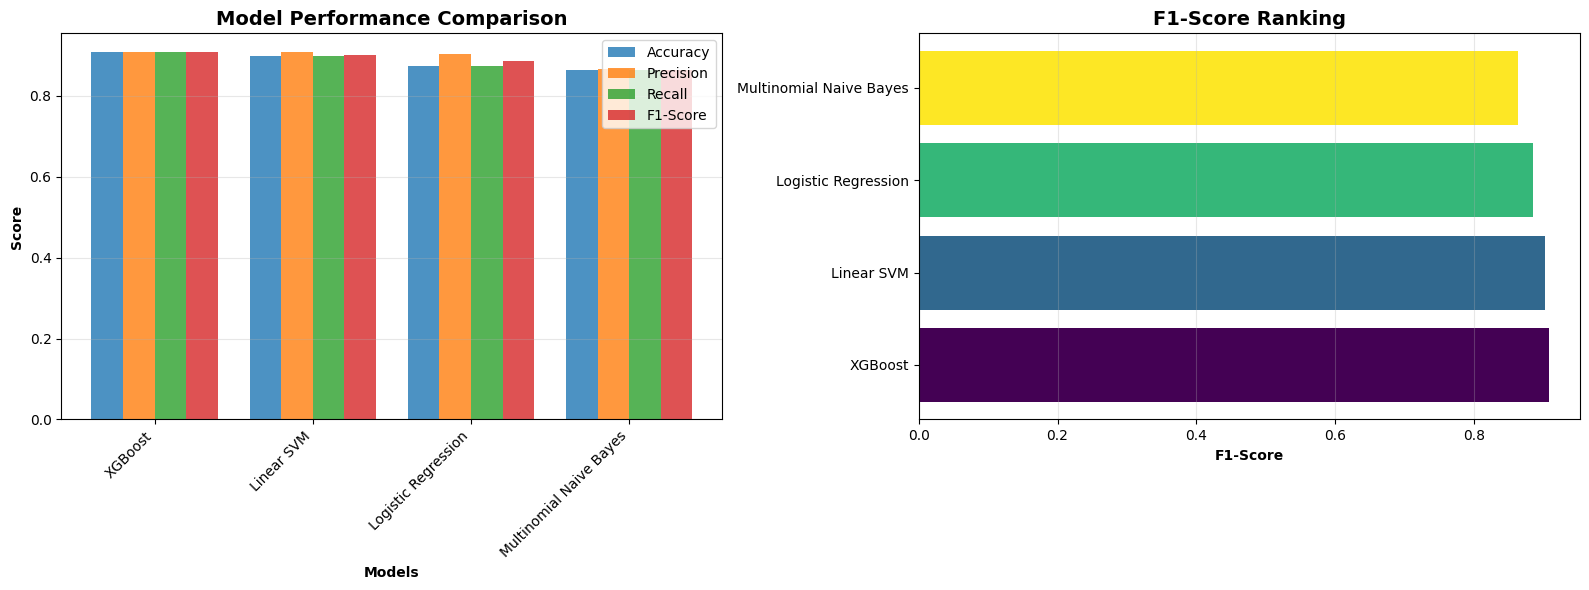

In [19]:

# ============================================================================
# STEP 6: MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("STEP 6: MODEL PERFORMANCE COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, comparison_df[metric], width, 
                label=metric, alpha=0.8)

axes[0].set_xlabel('Models', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: F1-Score ranking
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))
axes[1].barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
axes[1].set_xlabel('F1-Score', fontweight='bold')
axes[1].set_title('F1-Score Ranking', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Model comparison visualization saved as 'model_comparison.png'")




STEP 7: DETAILED MODEL EVALUATION

[7.1] Best Model: XGBoost
F1-Score: 0.9078

[7.2] Classification Report:
                  precision    recall  f1-score   support

Credit Reporting       0.92      0.95      0.93    167773
 Debt Collection       0.88      0.83      0.85     74326
   Consumer Loan       0.73      0.35      0.47      1892
        Mortgage       0.92      0.92      0.92     26967

        accuracy                           0.91    270958
       macro avg       0.86      0.76      0.79    270958
    weighted avg       0.91      0.91      0.91    270958


[7.3] Confusion Matrix:
[[159292   7327     99   1055]
 [ 11620  61723    129    854]
 [   623    444    654    171]
 [  1616    623     18  24710]]

✓ Confusion matrix saved as 'confusion_matrix.png'

[7.4] Top 20 Important Features:
✓ Feature importance plot saved as 'feature_importance.png'


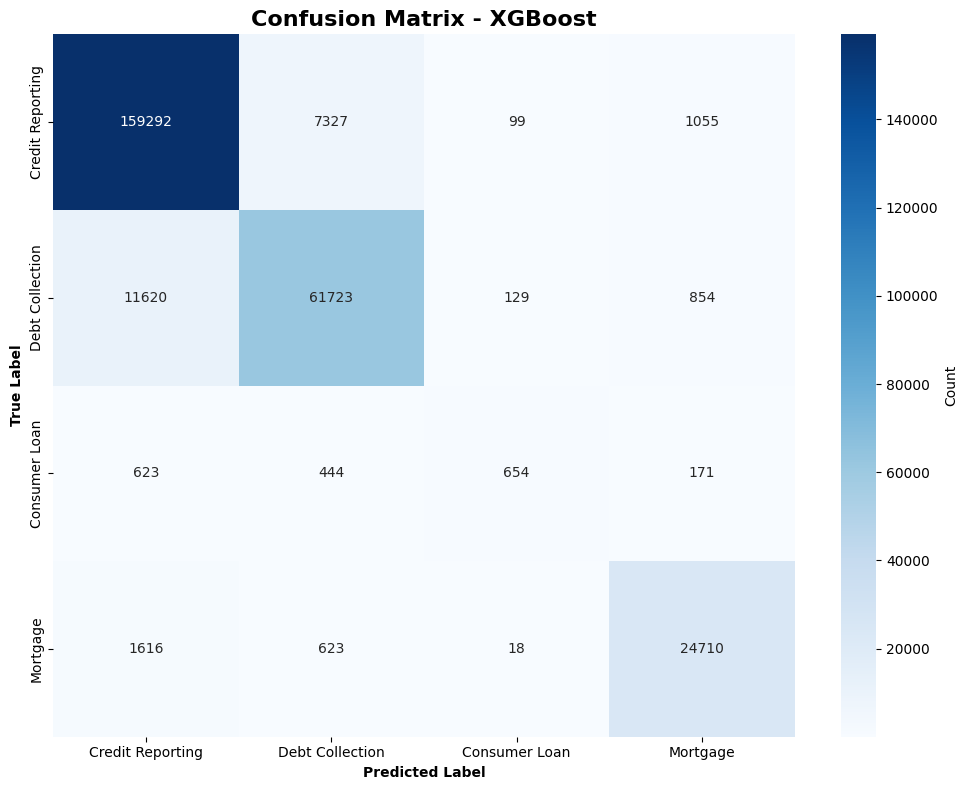

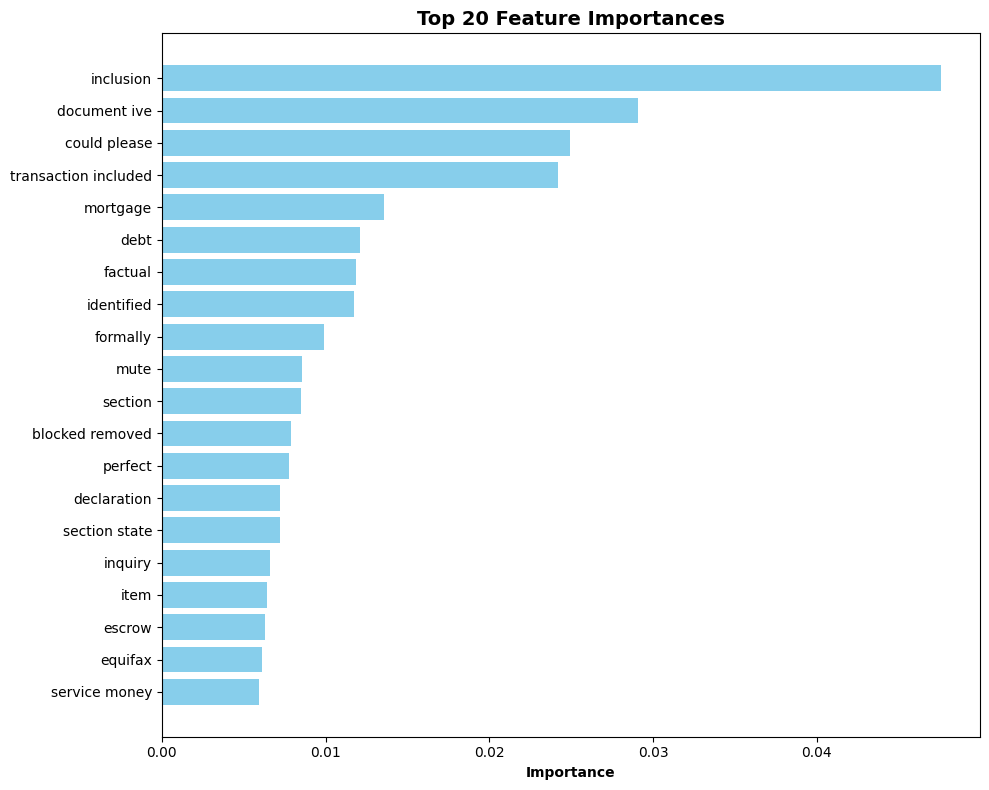

In [20]:
# ============================================================================
# STEP 7: DETAILED MODEL EVALUATION (BEST MODEL)
# ============================================================================
print("\n" + "="*80)
print("STEP 7: DETAILED MODEL EVALUATION")
print("="*80)

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n[7.1] Best Model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Classification Report
print("\n[7.2] Classification Report:")
class_names = ['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']
print(classification_report(y_test, best_predictions, target_names=class_names))

# Confusion Matrix
print("\n[7.3] Confusion Matrix:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved as 'confusion_matrix.png'")

# Feature Importance (if applicable)
if hasattr(best_model, 'feature_importances_'):
    print("\n[7.4] Top 20 Important Features:")
    feature_names = tfidf_vectorizer.get_feature_names_out()
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-20:]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], color='skyblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Feature importance plot saved as 'feature_importance.png'")

elif hasattr(best_model, 'coef_'):
    print("\n[7.4] Top 20 Features by Coefficient:")
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Get coefficients for each class
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx, class_name in enumerate(class_names):
        coef = best_model.coef_[idx]
        top_indices = np.argsort(np.abs(coef))[-15:]
        top_features = [feature_names[i] for i in top_indices]
        top_coefs = coef[top_indices]
        
        colors = ['red' if c < 0 else 'green' for c in top_coefs]
        axes[idx].barh(range(len(top_features)), top_coefs, color=colors, alpha=0.7)
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features)
        axes[idx].set_xlabel('Coefficient Value', fontweight='bold')
        axes[idx].set_title(f'Top Features - {class_name}', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    print("✓ Feature coefficients plot saved as 'feature_coefficients.png'")


In [21]:
# ============================================================================
# STEP 8: HYPERPARAMETER TUNING 
# ============================================================================
print("\n" + "="*80)
print("STEP 8: HYPERPARAMETER TUNING (BEST MODEL)")
print("="*80)

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    }
    tuning_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, 
                                      class_weight='balanced')
elif best_model_name == 'XGBoost':
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    }
    tuning_model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss', 
                                 use_label_encoder=False)
else:
    param_grid = None

if param_grid:
    print(f"\n[8.1] Performing GridSearchCV for {best_model_name}...")
    grid_search = GridSearchCV(
        tuning_model, param_grid, cv=3, scoring='f1_weighted', 
        n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_tfidf, y_train)
    
    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")
    
    # Use tuned model
    final_model = grid_search.best_estimator_
    final_predictions = final_model.predict(X_test_tfidf)
    final_f1 = f1_score(y_test, final_predictions, average='weighted')
    
    print(f"Test F1-Score (Tuned): {final_f1:.4f}")
else:
    final_model = best_model
    final_predictions = best_predictions



STEP 8: HYPERPARAMETER TUNING (BEST MODEL)

[8.1] Performing GridSearchCV for XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best CV F1-Score: 0.8019
Test F1-Score (Tuned): 0.8001


In [24]:
# ============================================================================
# STEP 9: PREDICTION FUNCTION
# ============================================================================
print("\n" + "="*80)
print("STEP 9: PREDICTION FUNCTION")
print("="*80)

def predict_complaint_category(complaint_text):
    """
    Predict the category of a new consumer complaint
    
    Args:
        complaint_text (str): The complaint text
    
    Returns:
        tuple: (predicted_label, predicted_category, confidence_scores)
    """
    # Preprocess text
    cleaned = preprocess_text(complaint_text)
    
    # Vectorize
    vectorized = tfidf_vectorizer.transform([cleaned])
    
    # Predict
    prediction = final_model.predict(vectorized)[0]
    
    # Get confidence scores if available
    if hasattr(final_model, 'predict_proba'):
        probabilities = final_model.predict_proba(vectorized)[0]
    else:
        probabilities = None
    
    category_names = {
        0: 'Credit reporting, repair, or other',
        1: 'Debt collection',
        2: 'Consumer Loan',
        3: 'Mortgage'
    }
    
    return prediction, category_names[prediction], probabilities

# Test predictions
print("\n[9.1] Testing prediction function with sample complaints:\n")

sample_complaints = [
    "My credit report has incorrect information that I've disputed multiple times but hasn't been fixed.",
    "A debt collector keeps calling me multiple times a day about a debt I don't owe.",
    "I applied for a personal loan but was denied without proper explanation.",
    "My mortgage payment increased significantly without proper notice from the lender."
]

for i, complaint in enumerate(sample_complaints, 1):
    pred_label, pred_category, probs = predict_complaint_category(complaint)
    print(f"Sample {i}:")
    print(f"Complaint: {complaint[:100]}...")
    print(f"Predicted Category: {pred_category}")
    if probs is not None:
        print(f"Confidence Scores: {dict(zip(class_names, probs))}")
    print()



STEP 9: PREDICTION FUNCTION

[9.1] Testing prediction function with sample complaints:

Sample 1:
Complaint: My credit report has incorrect information that I've disputed multiple times but hasn't been fixed....
Predicted Category: Credit reporting, repair, or other
Confidence Scores: {'Credit Reporting': 0.62016124, 'Debt Collection': 0.17282958, 'Consumer Loan': 0.096783504, 'Mortgage': 0.11022566}

Sample 2:
Complaint: A debt collector keeps calling me multiple times a day about a debt I don't owe....
Predicted Category: Debt collection
Confidence Scores: {'Credit Reporting': 0.24773656, 'Debt Collection': 0.54312646, 'Consumer Loan': 0.09777835, 'Mortgage': 0.111358665}

Sample 3:
Complaint: I applied for a personal loan but was denied without proper explanation....
Predicted Category: Credit reporting, repair, or other
Confidence Scores: {'Credit Reporting': 0.43862185, 'Debt Collection': 0.18998128, 'Consumer Loan': 0.11417335, 'Mortgage': 0.25722355}

Sample 4:
Complaint: My mo

In [23]:
# ============================================================================
# STEP 10: SAVE MODEL AND ARTIFACTS
# ============================================================================
print("\n" + "="*80)
print("STEP 10: SAVING MODEL AND ARTIFACTS")
print("="*80)

import pickle

# Save the model
with open('complaint_classifier_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("✓ Model saved as 'complaint_classifier_model.pkl'")

# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✓ Vectorizer saved as 'tfidf_vectorizer.pkl'")

# Save model performance report
with open('model_performance_report.txt', 'w') as f:
    f.write("CONSUMER COMPLAINT CLASSIFICATION - MODEL PERFORMANCE REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Test F1-Score: {final_f1:.4f}\n")
    f.write(f"Test Accuracy: {accuracy_score(y_test, final_predictions):.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, final_predictions, target_names=class_names))
    f.write("\n\nModel Comparison:\n")
    f.write(comparison_df.to_string(index=False))

print("✓ Performance report saved as 'model_performance_report.txt'")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"\nFinal Model: {best_model_name}")
print(f"Test F1-Score: {final_f1:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print("\nAll artifacts saved successfully!")
print("- eda_visualizations.png")
print("- model_comparison.png")
print("- confusion_matrix.png")
print("- complaint_classifier_model.pkl")
print("- tfidf_vectorizer.pkl")
print("- model_performance_report.txt")


STEP 10: SAVING MODEL AND ARTIFACTS
✓ Model saved as 'complaint_classifier_model.pkl'
✓ Vectorizer saved as 'tfidf_vectorizer.pkl'
✓ Performance report saved as 'model_performance_report.txt'

PROJECT COMPLETED SUCCESSFULLY!

Final Model: XGBoost
Test F1-Score: 0.8001
Test Accuracy: 0.8122

All artifacts saved successfully!
- eda_visualizations.png
- model_comparison.png
- confusion_matrix.png
- complaint_classifier_model.pkl
- tfidf_vectorizer.pkl
- model_performance_report.txt
